# Introduction
- ridgeでstackingを行う
- hyperopt でチューニングも行う

# Import everything I need :)

In [48]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from fastprogress import progress_bar

# Preparation

In [49]:
nb = 94
isSmallSet = False
length = 10000
model_name = 'ridge'

In [50]:
pd.set_option('display.max_columns', 200)

In [51]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/structures.zip',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',


In [52]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
    
type_train = train.type.values

In [53]:
# train
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path) [:length]
else:
    test = pd.read_csv(path)
    
type_test = test.type.values

## myFunc
**metrics**

In [54]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

# Stacking

In [55]:
path_list = [
'nb60_{}_lgb_-1.5330660525700779.csv',
'nb79_{}_extra_trees_regressor_-1.56760.csv',
'nb80_{}_extra_trees_regressor_-1.48000.csv',
'nb81_{}_bagging_regressor_-1.44452.csv',
'nb82_{}_bagging_regressor_-1.36181.csv',
'nb84_{}_extra_trees_regressor_-1.60943.csv',
'nb85_{}_extra_trees_regressor_-1.52972.csv',
'nb88_{}_lgb_-1.547953965914086.csv',
'nb91_{}_extra_trees_regressor_-1.47467.csv',
]

In [56]:
# oof
oofs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('oof'))[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('oof'))
    oofs.append(df)

In [57]:
# sub
subs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)
    subs.append(df)

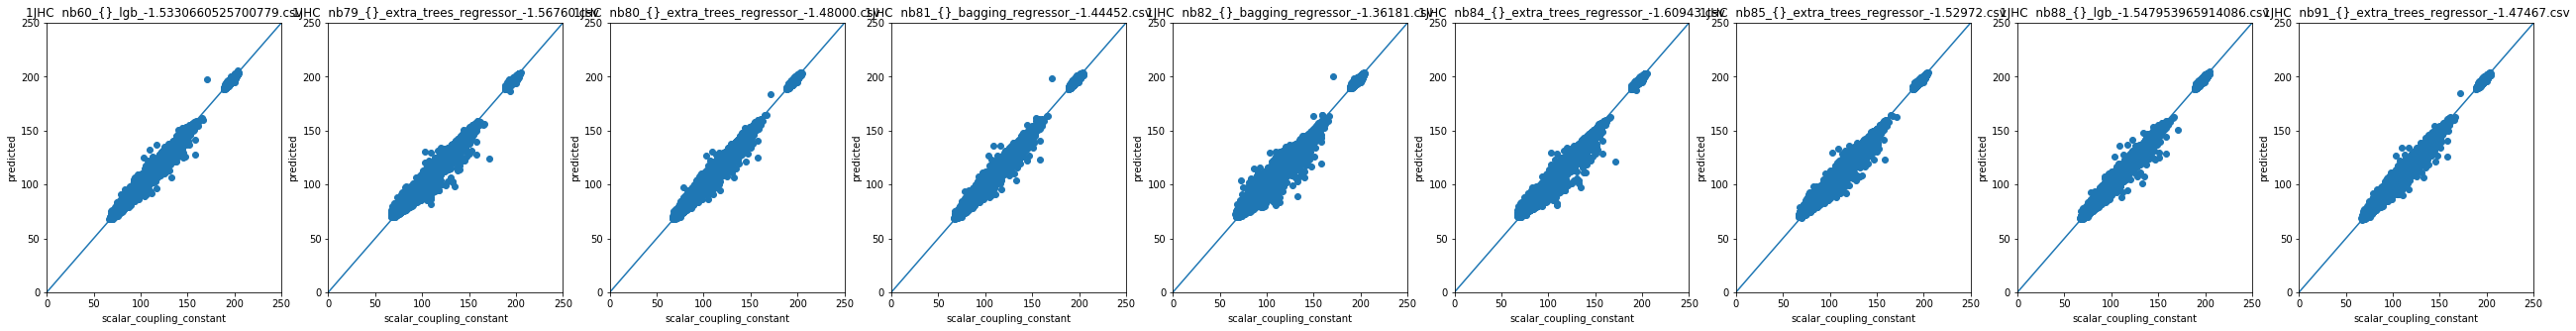

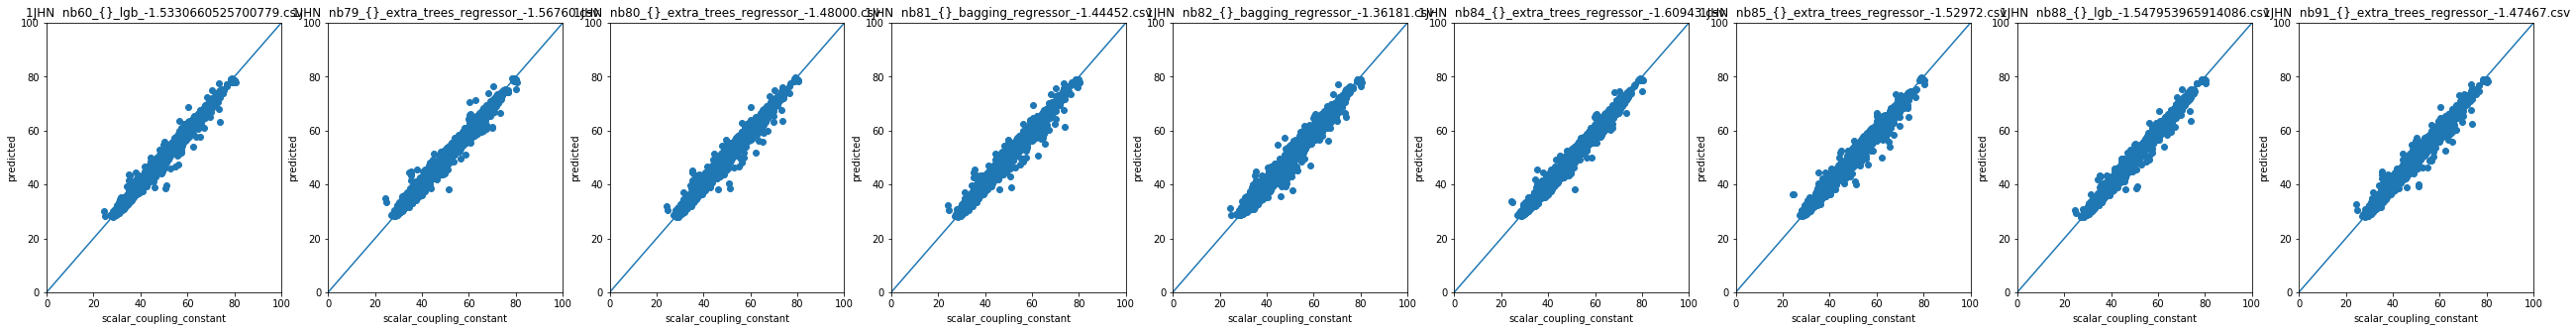

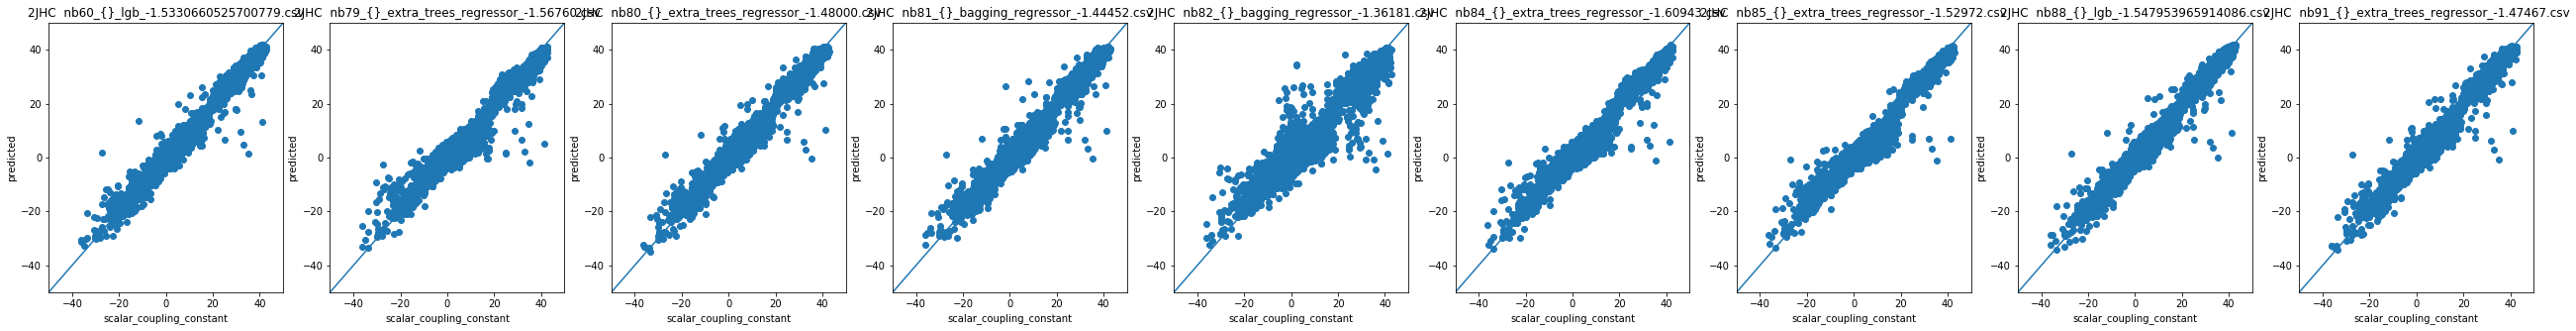

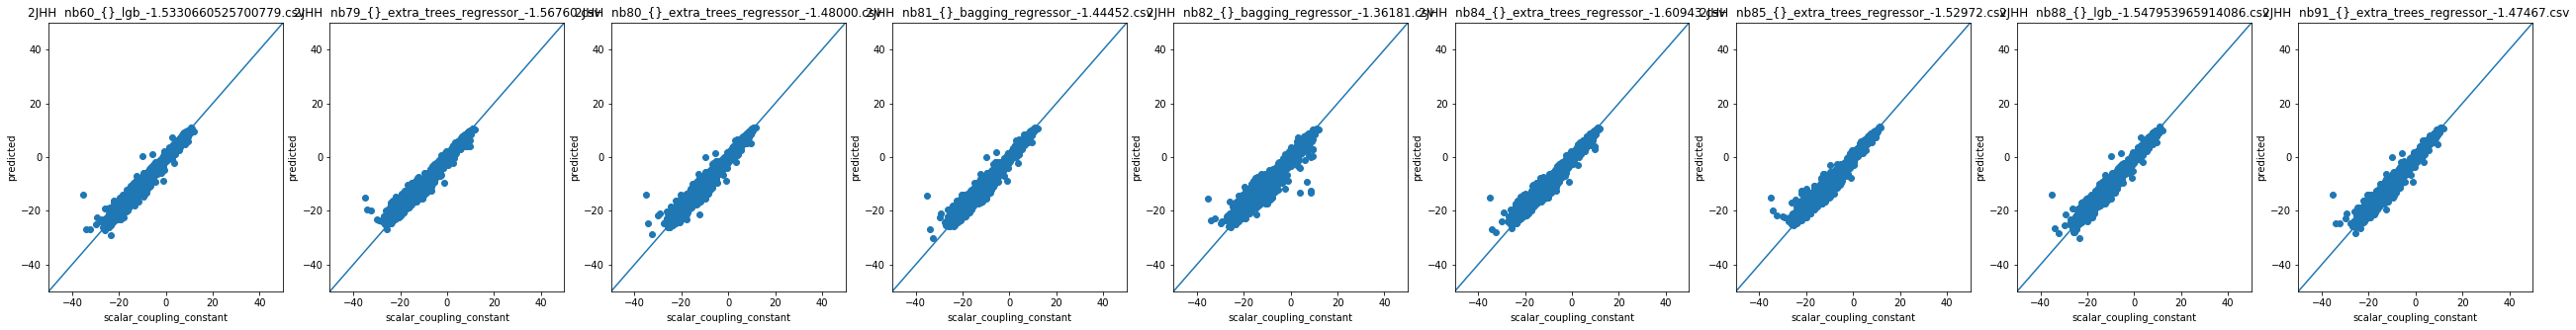

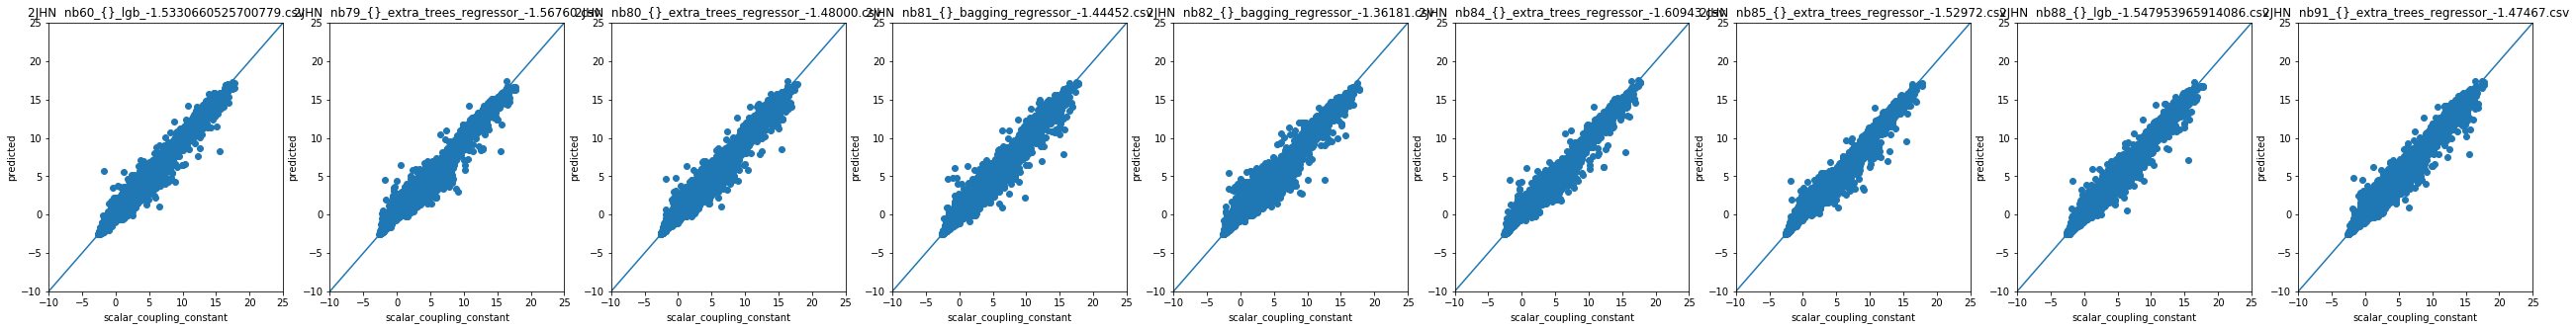

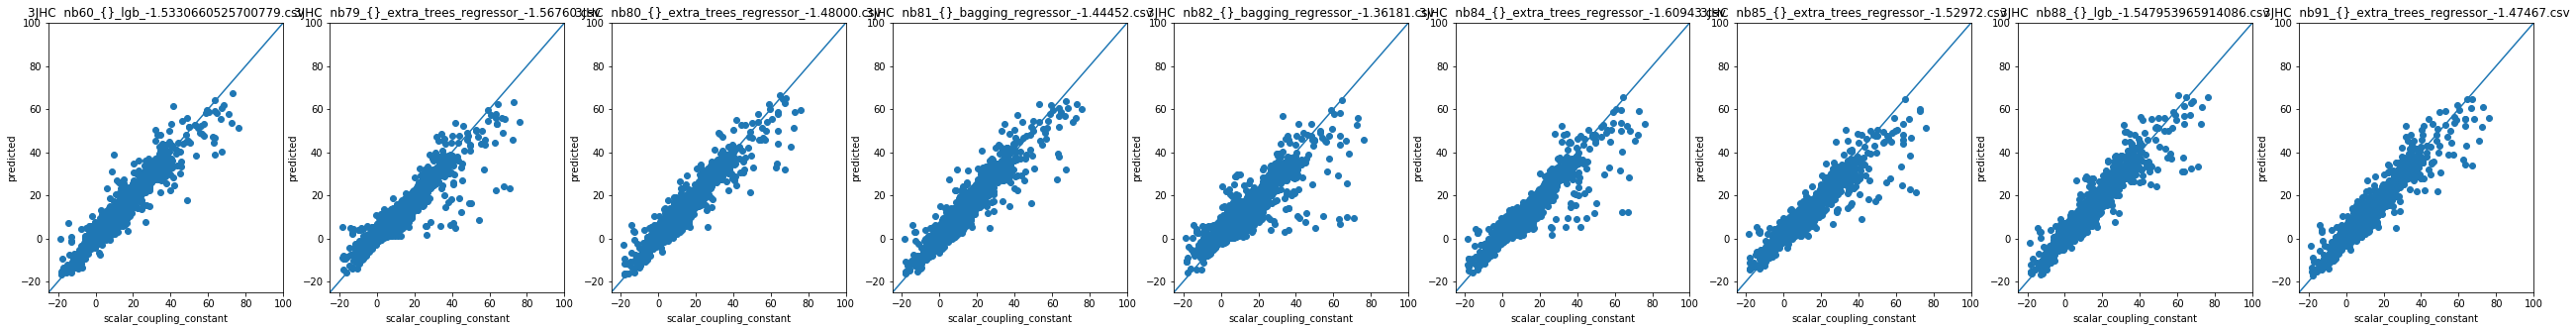

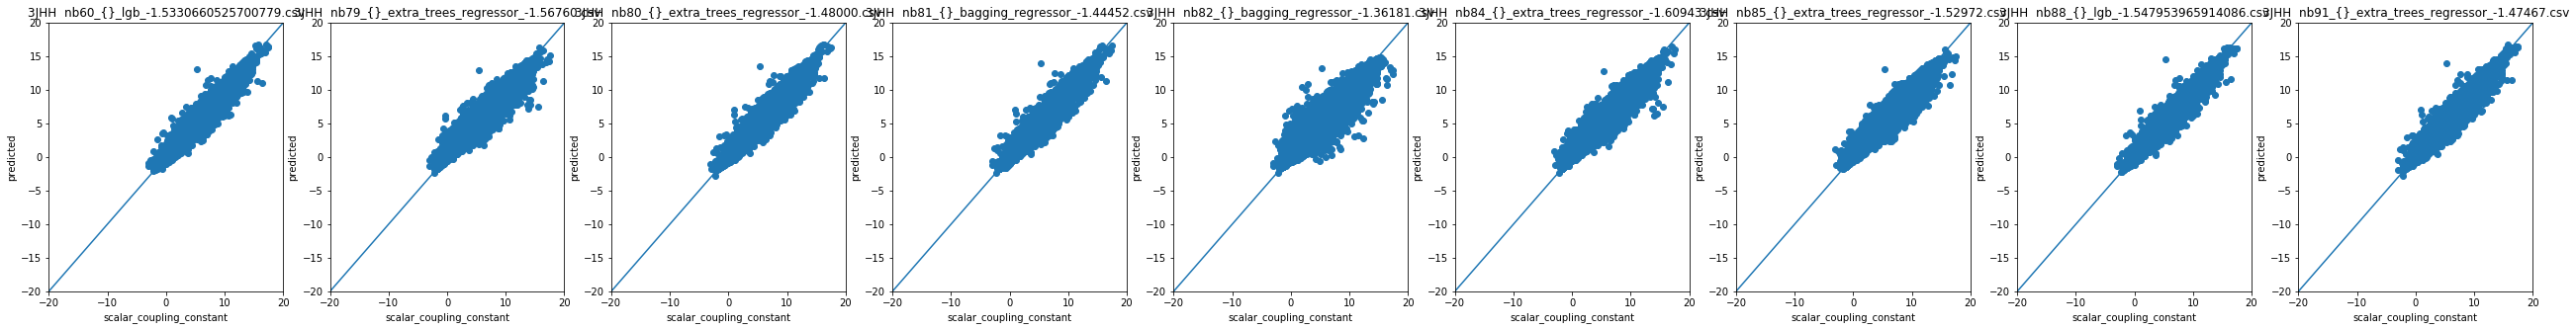

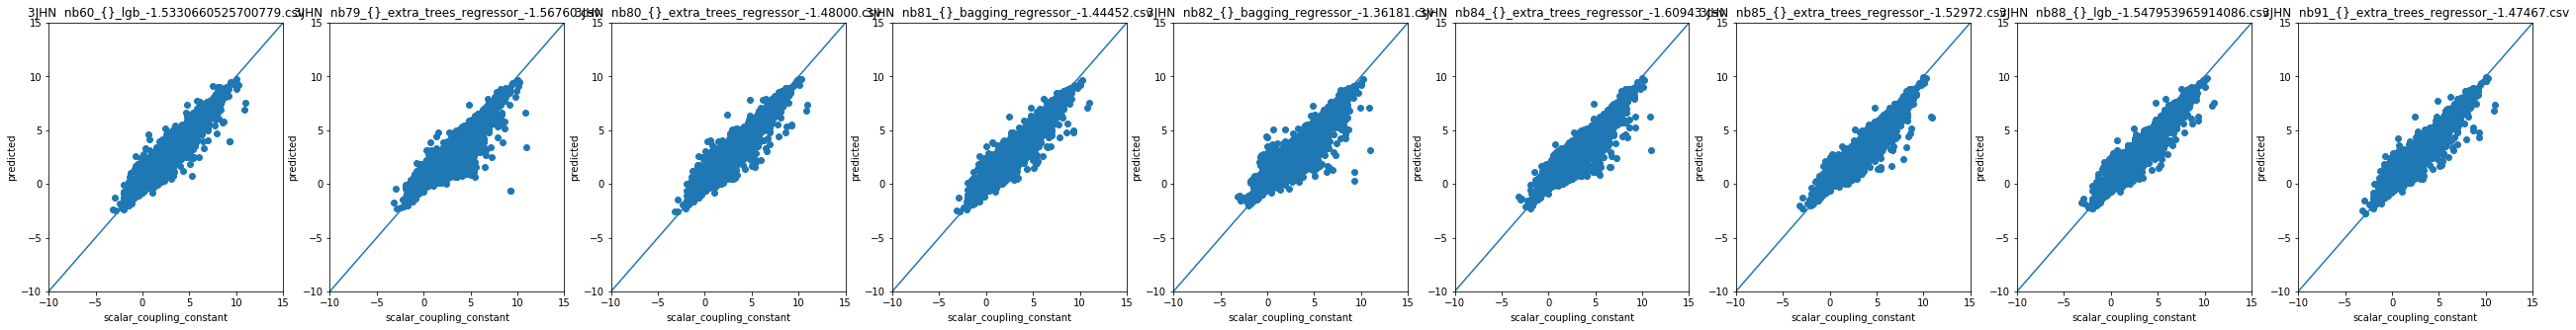

In [58]:
oof_list = [df.oof.values for df in oofs ] 
model_names = path_list
# types = lbl.inverse_transform(X['type'])
types = type_train

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
        y = train.scalar_coupling_constant.values
        axs[i].scatter(y[t_idx], oof_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('scalar_coupling_constant')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 25)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)

# Create train, test data

LabelEncode
- `type`   = {2JHC, ...}

In [99]:
lbl = LabelEncoder()
lbl.fit(list(type_train) + list(type_test))
type_train_lbl = lbl.transform(type_train)
type_test_lbl = lbl.transform(type_test)

In [100]:
y = train.scalar_coupling_constant
X = pd.concat(oofs, axis=1)
X = pd.DataFrame(X.values, columns=path_list)
X_test = pd.concat(subs, axis=1)
X_test = pd.DataFrame(X_test.values, columns=path_list)
X['type'] = type_train_lbl
X_test['type'] = type_test_lbl

# Hyperopt

In [101]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.30, 
                                                  random_state = 0)

In [102]:
# Define searched space
log_list = np.logspace(0.1, 2, 40)
hyper_space = {'alpha': hp.choice('alpha', log_list)}

# Seting the number of Evals
MAX_EVALS= 35
print(f'log_list: \n {log_list}')

log_list: 
 [  1.25892541   1.40837384   1.57556345   1.76260033   1.97184056
   2.20591993   2.46778711   2.76074085   3.08847144   3.45510729
   3.8652669    4.324117     4.8374377    5.41169527   6.05412358
   6.77281528   7.57682366   8.47627675   9.48250492  10.60818355
  11.86749273  13.27629589  14.85233963  16.61547726  18.58791891
  20.79451128  23.26305067  26.0246331   29.11404602  32.57020656
  36.43665173  40.76208688  45.6009992   51.01434415  57.07031326
  63.84519314  71.4243265   79.90318714  89.38858268 100.        ]


In [88]:
%%time
# type ごとの学習 

best_params_list = []
# for t in sorted(X_train['type'].unique()):
for t in sorted(np.unique(type_train_lbl)):
    print('*'*80)
    print(f'- Training of type {t}')
    print('*'*80)
    X_t_train = X_train.loc[X_train['type'] == t]
    X_t_valid = X_valid.loc[X_valid['type'] == t]
    y_t_train = y_train[X_train['type'] == t]
    y_t_valid = y_valid[X_valid['type'] == t]
    
    
    # evaluate_metric
    def evaluate_metric(params):
        model = linear_model.Ridge(**params, random_state=42, max_iter=3000)  # <=======================
        model.fit(X_t_train, y_t_train)

        pred = model.predict(X_t_valid)
        y_t_train_pred = model.predict(X_t_train)

        _X_t_valid = X_t_valid.copy()
        _X_t_valid['scalar_coupling_constant'] = y_t_valid
        cv_score = kaggle_metric(_X_t_valid, pred)
        _X_t_valid = _X_t_valid.drop(['scalar_coupling_constant'], axis=1)

#         print(f'mae(valid): {mean_absolute_error(y_t_valid, pred)}')
        
        print(params)
        print(f'training l1: {mean_absolute_error(y_t_train, y_t_train_pred) :.5f}	\t valid l1: {mean_absolute_error(y_t_valid, pred) :.5f} ')
        print(f'cv_score: {cv_score}')
        print('-'*80)
        print('\n')

        return {
            'loss': cv_score,
            'status': STATUS_OK,
            'stats_running': STATUS_RUNNING
        }
    
    
    # hyperopt
    # Trail
    trials = Trials()

    # Set algoritm parameters
    algo = partial(tpe.suggest, 
                   n_startup_jobs=-1)


    # Fit Tree Parzen Estimator
    best_vals = fmin(evaluate_metric, space=hyper_space, verbose=1,
                     algo=algo, max_evals=MAX_EVALS, trials=trials)

    # Print best parameters
    best_params = space_eval(hyper_space, best_vals)
    best_params_list.append(best_params)
    print("BEST PARAMETERS: " + str(best_params))
    print('')

********************************************************************************
- Training of type 0
********************************************************************************
{'alpha': 5.411695265464636}                        
training l1: 0.54994		 valid l1: 0.54797            
cv_score: -0.6015295035861482                       
--------------------------------------------------------------------------------
{'alpha': 5.411695265464636}                                                  
training l1: 0.54994		 valid l1: 0.54797                                      
cv_score: -0.6015295035861482                                                 
--------------------------------------------------------------------------------
{'alpha': 2.760740847324663}                                                  
training l1: 0.54994		 valid l1: 0.54797                                      
cv_score: -0.6015290717771778                                                 
----------------------

In [89]:
best_params_list

[{'alpha': 40.762086875748885},
 {'alpha': 89.38858267996869},
 {'alpha': 63.84519314384512},
 {'alpha': 100.0},
 {'alpha': 51.01434415464325},
 {'alpha': 89.38858267996869},
 {'alpha': 79.90318713533594},
 {'alpha': 89.38858267996869}]

# Training model

**params**

In [103]:
# Configuration
MAX_ITER = 10000
RANDOM_STATE = 0

model_params_list = best_params_list

In [104]:
n_folds = 12
folds = KFold(n_splits=n_folds, shuffle=True)

In [105]:
def train_model(X, X_test, y, folds, model_params):
#     model = linear_model.Ridge(**model_params, max_iter=MAX_ITER, random_state=RANDOM_STATE)  # <=================

    scores = []
    oof = np.zeros(len(X))  
    prediction = np.zeros(len(X))  
    result_dict = {}
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        model = linear_model.Ridge(**model_params, max_iter=MAX_ITER, random_state=RANDOM_STATE)  # <=================
        model.fit(X.iloc[train_idx, :], y[train_idx])
        y_valid_pred = model.predict(X.iloc[valid_idx, :])
        y_train_pred = model.predict(X.iloc[train_idx, :])
        prediction = model.predict(X_test)
        oof[valid_idx] = y_valid_pred
        score = mean_absolute_error(y[valid_idx], y_valid_pred)
        score_train = mean_absolute_error(y[train_idx], y_train_pred)
        scores.append(score)

        print(f'fold {fold_n+1} train:{score_train :.5f} \t valid: {score :.5f}')
        print('')
    print('CV mean score    : {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('kaggle mean score: {0:.4f}'.format(np.log(np.mean(scores)))) 
    print('')
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    return result_dict

In [109]:
%%time
# type ごとの学習 

X_short = pd.DataFrame({'ind': list(X.index), 'type': type_train, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': type_test, 'prediction': [0] * len(X_test)})
for i, t in enumerate(np.unique(type_train)):
    idx = lbl.transform([t])[0]
    model_params = model_params_list[idx]
    print(model_params)
    print('*'*80)
    print(f'Training of type {t}')
    print('*'*80)
    X_t = X.loc[type_train == t]
    X_test_t = X_test.loc[type_test == t]
    y_t = X_short.loc[type_train == t, 'target'].values
    
    result_dict = train_model(X_t, X_test_t, y_t, folds, model_params)
    X_short.loc[type_train == t, 'oof'] = result_dict['oof']
    X_short_test.loc[type_test == t, 'prediction'] = result_dict['prediction']
    
    

print('')
print('===== finish =====')
X['scalar_coupling_constant'] = y
metric = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
prediction = X_short_test['prediction']

{'alpha': 40.762086875748885}
********************************************************************************
Training of type 1JHC
********************************************************************************
Fold 1 started at Tue Aug 27 21:37:54 2019
fold 1 train:0.54912 	 valid: 0.54947

Fold 2 started at Tue Aug 27 21:37:55 2019
fold 2 train:0.54934 	 valid: 0.54745

Fold 3 started at Tue Aug 27 21:37:55 2019
fold 3 train:0.54875 	 valid: 0.55305

Fold 4 started at Tue Aug 27 21:37:55 2019
fold 4 train:0.54888 	 valid: 0.55175

Fold 5 started at Tue Aug 27 21:37:56 2019
fold 5 train:0.54889 	 valid: 0.55203

Fold 6 started at Tue Aug 27 21:37:56 2019
fold 6 train:0.54926 	 valid: 0.54801

Fold 7 started at Tue Aug 27 21:37:56 2019
fold 7 train:0.54927 	 valid: 0.54810

Fold 8 started at Tue Aug 27 21:37:57 2019
fold 8 train:0.54914 	 valid: 0.54967

Fold 9 started at Tue Aug 27 21:37:57 2019
fold 9 train:0.54904 	 valid: 0.54783

Fold 10 started at Tue Aug 27 21:37:57 2019
fold

# Save

**submission**

In [69]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = f'../output/nb{nb}_stack_submission_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_submittion}')

save pash: ../output/nb94_stack_submission_ridge_-1.74196.csv


In [70]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
submittion['scalar_coupling_constant'] = prediction
if isSmallSet:
    pass
else:
    submittion.to_csv(path_submittion, index=False)

---
**result**

In [71]:
path_oof = f'../output/nb{nb}_stack_oof_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_oof}')

save pash: ../output/nb94_stack_oof_ridge_-1.74196.csv


In [72]:
oof = pd.DataFrame(X_short['oof'])
if isSmallSet:
    pass
else:
    oof.to_csv(path_oof, index=False)

# analysis

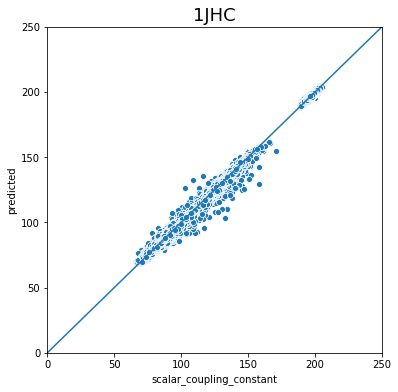

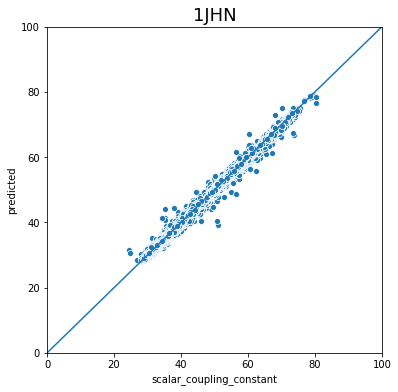

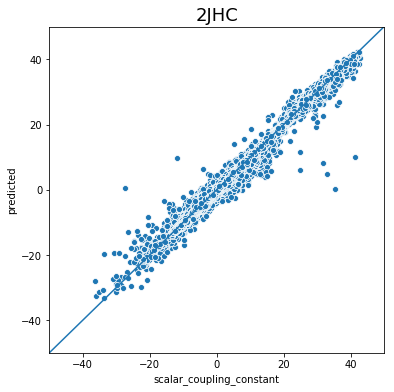

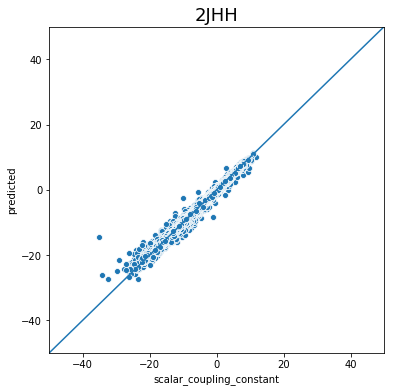

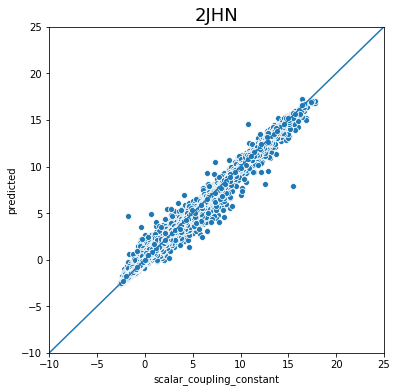

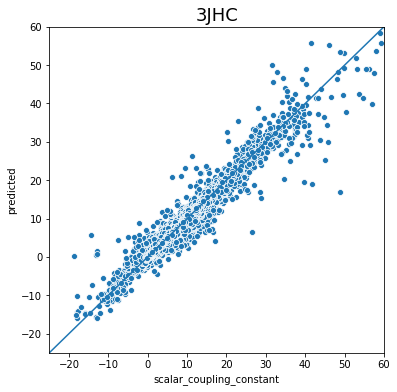

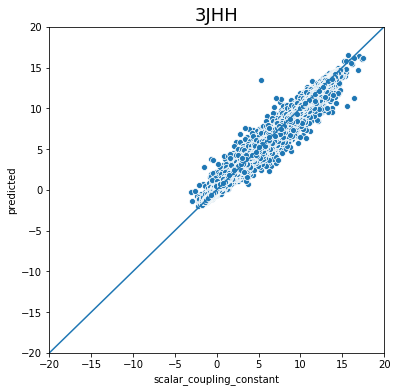

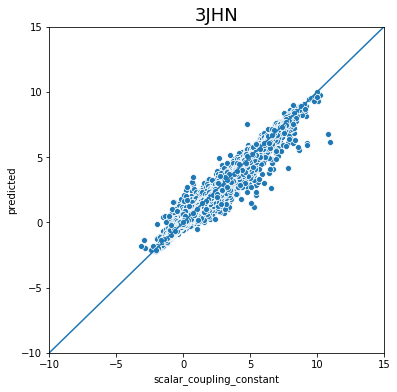

In [110]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 60)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)